In [36]:
# Base packages
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

# Defined packages
from inputs import RandomPattern
from neuralBehaviors import *
from metrics import draw_weights

# PyMonnTorch and CoNeX
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder, Recorder

from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP
from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace, Fire, KWTA
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure
from conex.behaviors.neurons.neuron_types.lif_neurons import LIF




SIZE = 10
TIME = 30
NORM = 10
dataset = RandomPattern(
    pattern1=[1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    pattern2=[0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    period=20,
)


net = Neocortex(dt=1)

input_layer = NeuronGroup(size=SIZE, net=net, behavior={
    **prioritize_behaviors([
        LIF(R=100, threshold=-50, tau=1, v_reset=-75, v_rest=-65),
        Fire(), 
        SpikeTrace(tau_s=0.9),
        NeuronAxon(), 
        ]),
    160: ResetIBehavior(),
    170: InputBehavior(dataset),
    500: EventRecorder(variables=['spikes']),
})

out_ng = NeuronGroup(net=net, size=2, tag='out', behavior={**prioritize_behaviors(
    [
        SimpleDendriteStructure(),
        LIF(R=0.5, threshold=-50, tau=1, v_reset=-75, v_rest=-65),
        KWTA(k=1),
        Fire(),
        SpikeTrace(tau_s=0.9),
        NeuronAxon(),
        
    ]),
    # 160: ResetIBehavior(),
    170: InputBehavior(),
    180: LateralInhibition(alpha=100),
    # 260: LIFBehavior(R=300, adaptive=False),
    330: Recorder(variables=['v']),
    490: Recorder(variables=['v']),
    500: EventRecorder(variables=['spikes']),
    })
synapsis_input_out = SynapseGroup(net=net, src=input_layer, dst=out_ng, behavior=
                                    prioritize_behaviors(
                                      [
                                        SynapseInit(), 
                                        SimpleDendriticInput(),
                                        WeightInitializer(mode='random', weight_shape=(10, 2), scale=1 + NORM // SIZE), 
                                        WeightNormalization(norm=NORM),
                                        # SimpleSTDP(a_plus=1, a_minus=1),
                                      ]
                                    ), tag="Proximal")



net.initialize(info=False)
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(50, measure_block_time=False)
newW = synapsis_input_out.weights.clone()

print(f"\nDiff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer['spikes'][0].shape[0]}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")



Proximal I before: tensor([0., 0.]), syn: tensor([[0, 0]]), I = tensor([[0., 0.]])
Proximal I after: tensor([0., 0.])
I = tensor([0., 0.])
V before: tensor([0., 0.]), spikes: tensor([True, True])
V after: tensor([-65., -65.]), spikes: tensor([True, True])
Proximal I before: tensor([156., 156.]), syn: tensor([[0, 0]]), I = tensor([[4.8635, 3.8487]])
Proximal I after: tensor([4.8635, 3.8487])
I = tensor([156., 156.])
V before: tensor([-65., -65.]), spikes: tensor([False, False])
V after: tensor([13., 13.]), spikes: tensor([False, False])
Proximal I before: tensor([156., 312.]), syn: tensor([[0, 0]]), I = tensor([[4.8635, 3.8487]])
Proximal I after: tensor([4.8635, 3.8487])
I = tensor([156., 312.])
V before: tensor([-75., -75.]), spikes: tensor([ True, False])
V after: tensor([13., 91.]), spikes: tensor([ True, False])
Proximal I before: tensor([312., 312.]), syn: tensor([[0, 0]]), I = tensor([[4.8635, 3.8487]])
Proximal I after: tensor([4.8635, 3.8487])
I = tensor([312., 312.])
V before:

In [37]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

print(out_ng['I'][0][:, 0])


tensor([   0.,  156.,  156.,  312.,  312.,  468.,  468.,  624.,  624.,  780.,
         780.,  936.,  936., 1092., 1092., 1248., 1248., 1404., 1404., 1560.,
        1560., 1716., 1716., 1872., 1872., 2028., 2028., 2184., 2184., 2340.,
        2340., 2496., 2496., 2652., 2652., 2808., 2808., 2964., 2964., 3120.,
        3120., 3276., 3276., 3432., 3432., 3588., 3588., 3744., 3744., 3900.])


Patterns:
	1: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0])
	2:tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([[1.6410, 0.9664],
        [1.2744, 0.2845],
        [1.8905, 1.0956],
        [0.6087, 0.3836],
        [1.7511, 0.3685],
        [1.3120, 0.1873],
        [0.2257, 1.7980],
        [1.3146, 0.1237],
        [0.3334, 1.3173],
        [1.9197, 1.3385]])
tensor([12.2711,  7.8634])
tensor([[1.3430, 1.2282],
        [1.0456, 0.3599],
        [1.5339, 1.3949],
        [0.5054, 0.4861],
        [1.4324, 0.4669],
        [1.0639, 0.2379],
        [0.1825, 2.2886],
        [1.0666, 0.1575],
        [0.2699, 1.6765],
        [1.5569, 1.7035]])
tensor([10.0000, 10.0000])


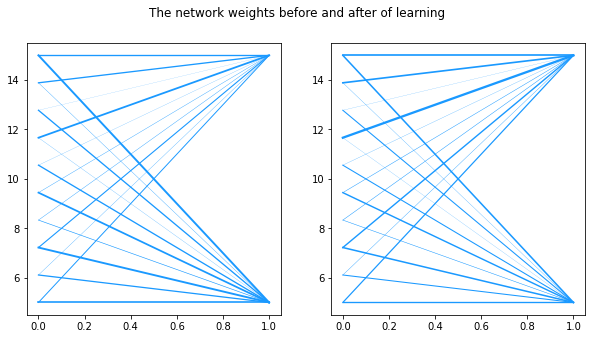

In [ ]:
import matplotlib.pyplot as plt
print(f"Patterns:\n\t1: {dataset.pats[0]}\n\t2:{dataset.pats[1]}")

print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
plt.suptitle("The network weights before and after of learning")
plt.show()


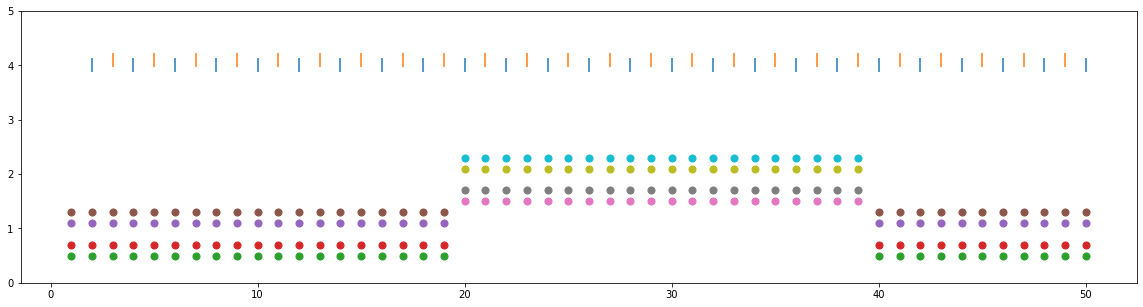

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 5))


spikes = out_ng['spikes'][0]
zeros = out_ng['spikes'][0][:, 1] == 0
firsts = spikes[zeros]
seconds = spikes[~zeros]
ax.scatter(x=out_ng['spikes', 0][zeros][:, 0], y=4 * torch.ones(zeros.sum()), marker='|', s=200)
ax.scatter(x=out_ng['spikes', 0][~zeros][:, 0], y=4.1 * torch.ones((~zeros).sum()), marker='|', s=200)


spikes = input_layer['spikes'][0]
for i in input_layer['spikes'][0][:, 1].unique():
    times = input_layer['spikes'][0][:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=0.5 + 0.2 * i * torch.ones(times.sum()), marker='.', s=200)
    
ax.set_ylim(0, 5)
plt.show()



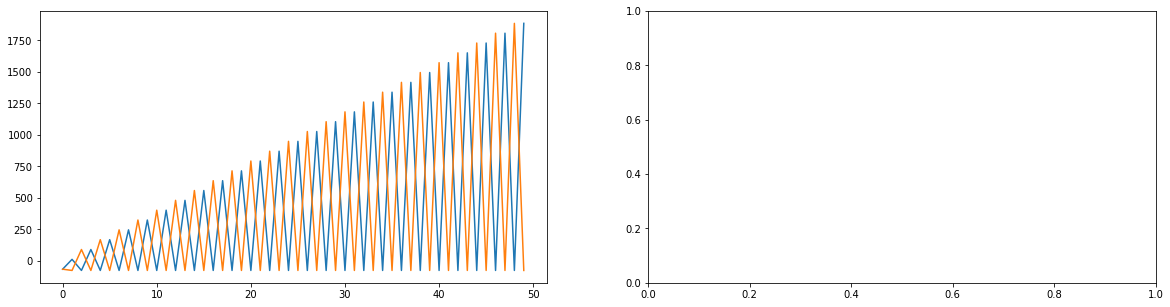

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
v = out_ng['v'][0]
ax[0].plot(v[:, 0])
ax[0].plot(v[:, 1])
plt.show()
